Reproducing the code in https://github.com/robertness/causalML/blob/master/projects/epidemic%20modeling/COVID-19-SIR-Model/notebooks/SIR-model.ipynb, and creating it in Pyro

In [13]:

import math
import re
from collections import OrderedDict

import torch
from torch import distributions as tdist
from pyro import distributions as dist

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import pyro.distributions as dist
import pyro.distributions.hmm
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, config_enumerate, infer_discrete
from pyro.infer.autoguide import init_to_value
from pyro.ops.special import safe_log
from pyro.ops.tensor_utils import convolve
from pyro.util import warn_if_nan

import pandas as pd
%matplotlib inline

In [33]:
# Loading the data
pop_data_ecdc = pd.read_csv(
    "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
)


def get_country_pop(country_geoID):
    pop = pop_data_ecdc[pop_data_ecdc.geoId == country_geoID].popData2019 # changed from 2018
    pop = pop.to_numpy()[0]
    return pop

In [15]:
pop_data_ecdc.head()


,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,27/11/2020,27,11,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,6.395604
1,26/11/2020,26,11,2020,200,12,Afghanistan,AF,AFG,38041757.0,Asia,7.341932
2,25/11/2020,25,11,2020,185,13,Afghanistan,AF,AFG,38041757.0,Asia,7.199983
3,24/11/2020,24,11,2020,246,17,Afghanistan,AF,AFG,38041757.0,Asia,6.713675
4,23/11/2020,23,11,2020,252,8,Afghanistan,AF,AFG,38041757.0,Asia,6.655844


In [16]:
# Exploratory Data Analysis



# Storing the url's
confirmed_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
url = {"confirmed": confirmed_url,
       "deaths": deaths_url,
       "recovered": recovered_url}


idata = pd.read_csv(confirmed_url)
ddata = pd.read_csv(deaths_url)
rdata = pd.read_csv(recovered_url)

In [17]:

def tidy_data(data, compartment):
    """
  Input: data, compartment:(confirmed/recovered/deaths)
  Output: Tidy data with cols as country, date, cases, new_cases, days_after_1
  "cases" refers to accumulated cases either(confirmed/recovered/death)
  "new_cases" refers to new case either(confirmed/recovered/death) per each day
   depending on type
  "days_after_1" refers to days passed since the confirmation/recovery/deaths
  of first positive covid-19 cases respectively for
  confirmed/recovered/deaths data
  """   
    # Merging all the dates using pd.melt()
    df_data = pd.melt(data, id_vars=["Province/State",
                                     "Country/Region",
                                     "Lat",
                                     "Long"],
                      value_name="Cases")
    # renaming the columns
    df_data.columns = ['state', 'country', 'Lat', 'Long', 'date', compartment]
    # converting the date column from string to date format
    df_data['date'] = pd.to_datetime(df_data.date)
    # sort by date
    df_data.sort_values(by=['country', 'date'], inplace=True)
    df_data.drop(['Lat', 'Long'], axis=1, inplace=True)
    # Merging province/state of countries to get accumulated data for country
    df_states_inc = (df_data.loc[~df_data.state.isna()]
                     .groupby(['country', 'date']).sum()
                     .rename(index=lambda x: x+' (all_states_inc)', level=0)
                     .reset_index(level=['country', 'date']))
    # appending the accumulated states data in the original dataframe
    df_data.append(df_states_inc, ignore_index=True)
    # droping the state column as it is not required for further modeling
    df_data = df_data.loc[df_data.state.isnull()]
    df_data.drop(['state'], axis=1, inplace=True)
    df_data.reset_index(drop=True, inplace=True)
    # creating a new cases column to track new cases per day for each country
    df_data['new_'+str(compartment)] = (df_data
                                        .groupby('country')[compartment]
                                        .diff())
    # creating a new column to track the days passed since the
    # confirmation of the first case in each country
    df_data['days_after_1'] = (df_data[compartment] > 0).astype(int)
    df_data['days_after_1'] = (df_data
                               .groupby('country')['days_after_1']
                               .cumsum())
    # filtering the data to include only the data since the first
    # case is confirmed for each country
    df_data = df_data[df_data[compartment] != 0]
    return df_data

In [18]:
tidy_idata = tidy_data(idata, 'confirmed')
df_small = tidy_idata[tidy_idata.country.isin(
    ['Italy', 'US',
     "Spain", "Korea, South",
     "Japan", "India"])]

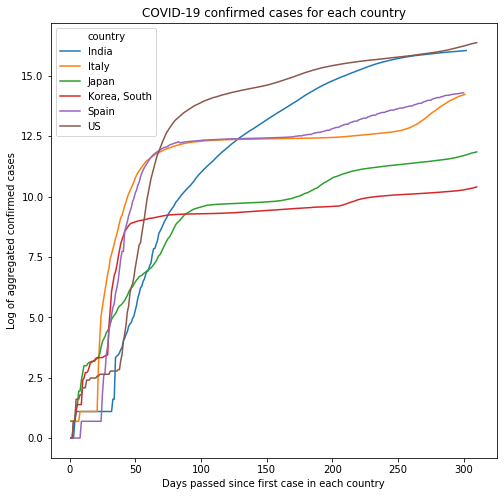

In [19]:
fig = plt.figure(figsize=[8, 8])
ax = sns.lineplot(x=df_small.days_after_1, y=np.log(df_small.confirmed),
                  hue=df_small['country'])
ax.set(xlabel='Days passed since first case in each country',
       ylabel='Log of aggregated confirmed cases')
ax.set_title('COVID-19 confirmed cases for each country')
plt.show()

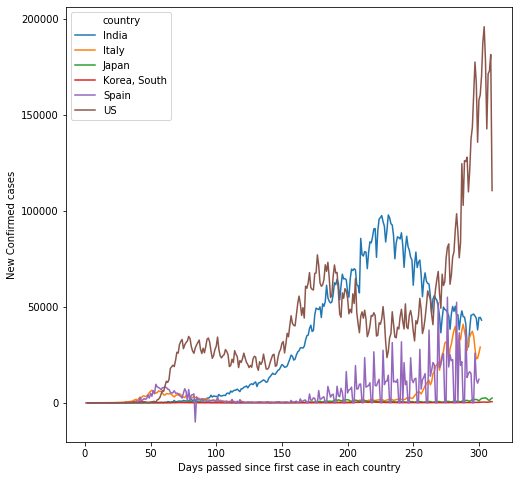

In [20]:
fig = plt.figure(figsize=[8, 8])
ax = sns.lineplot(x=df_small.days_after_1, y=df_small.new_confirmed,
                  hue=df_small['country'])
ax.set(xlabel='Days passed since first case in each country',
       ylabel='New Confirmed cases')
ax.set()
plt.show()

In [21]:
tidy_ddata = tidy_data(ddata, 'deaths')
df_small_death = tidy_ddata[tidy_ddata.country.isin(
    ['Italy', 'US',
     "Spain", "Korea,South",
     "Japan", "India"])]

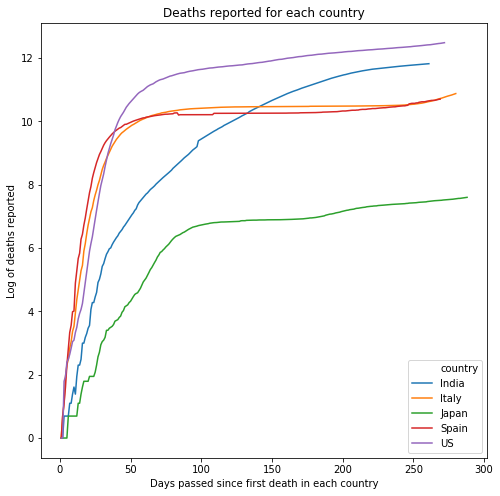

In [23]:

fig = plt.figure(figsize=[8, 8])
ax = sns.lineplot(x=df_small_death.days_after_1.values,
                  y=np.log(df_small_death.deaths),
                  hue=df_small_death['country'])
ax.set(xlabel='Days passed since first death in each country',
       ylabel='Log of deaths reported')
plt.title("Deaths reported for each country")
plt.show()

In [24]:
tidy_rdata = tidy_data(rdata, 'recovered')
df_small_recovered = tidy_rdata[tidy_rdata.country
                                .isin(['Italy', 'US',
                                       "Spain", "Korea, South",
                                       "Japan", "India"])]

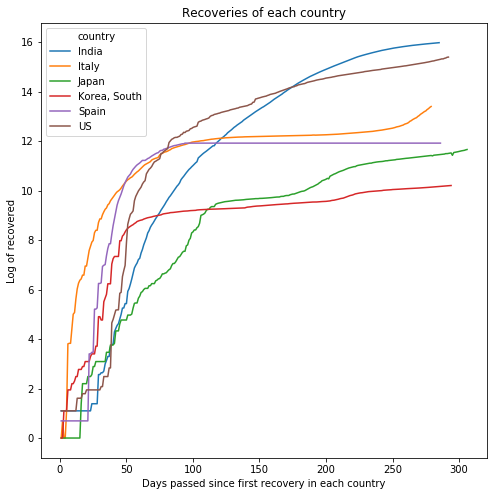

In [26]:
fig = plt.figure(figsize=[8, 8])
ax = sns.lineplot(x=df_small_recovered.days_after_1.values,
                  y=np.log(df_small_recovered.recovered.values),
                  hue=df_small_recovered['country'])
ax.set(xlabel='Days passed since first recovery in each country',
       ylabel='Log of recovered')
plt.title("Recoveries of each country")
plt.show()

# Generate data for the model

In [35]:
# Create a class to read and prepare the data in a numpy
# array with columns S, I, and R


class constructData():
    """
    Reads in data URLs and constructs the country's info in a numpy array
    """
    def __init__(self, url):
        self.url = url
        self.idata = pd.read_csv(url["confirmed"])
        self.ddata = pd.read_csv(url["deaths"])
        self.rdata = pd.read_csv(url["recovered"])

    def get_data(self, country, tot_pop):
        """
        Extract country's data from global data
        Aggregate recovered (alive) and deaths into R
        """
        Infected = self.construct_data(self.idata, country)
        R1 = self.construct_data(self.rdata, country)
        R2 = self.construct_data(self.ddata, country)
        Resistant = R1 + R2
        Infected = Infected - Resistant
        Susceptible = tot_pop - Infected - Resistant

        sir = np.hstack([Susceptible, Infected, Resistant])
        return sir

    def construct_data(self, data, country):
        """
        Filter the country's data and put them in a numpy array
        """
        arr = data[data["Country/Region"] == country].iloc[0, :][4:]
        arr = arr.to_numpy()
        arr = arr.astype("float32")
        return arr.reshape(-1, 1)

In [36]:
# The United States 

US_tot_pop = get_country_pop("US")
data = constructData(url)
us = data.get_data("US", US_tot_pop)

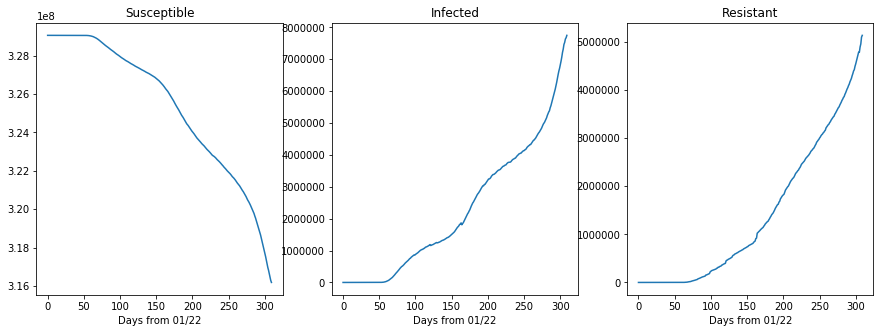

In [37]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(us[:, 0])
plt.xlabel("Days from 01/22")
plt.title("Susceptible")

plt.subplot(1, 3, 2)
plt.plot(us[:, 1])
plt.xlabel("Days from 01/22")
plt.title("Infected")

plt.subplot(1, 3, 3)
plt.plot(us[:, 2])
plt.xlabel("Days from 01/22")
plt.title("Resistant")

plt.show()

In [38]:
# ODE

# Initialzie differential equations used in SIR to show change in each compartment per unit time. 



In [39]:
def dz_dt(z, t, gamma, delta): 
    """
    Computes the change in one timestep according to ODEs
    z: components of the system that can vary through time (s, i, r, beta)
    t: timesteps
    gamma: the recovery rate (includes rates for both recovered (alive) and deaths)
    delta: the rate at which beta (the transmission rate) changes
    """
    s, i, r, beta = z
    N = s + i + r

    # ODEs
    ds_dt = -beta * (i/N) * s
    di_dt = beta * (i/N) * s - gamma * i 
    dr_dt = gamma * i
    dbeta_dt = -beta * delta

    return np.stack([ds_dt, di_dt, dr_dt, dbeta_dt])

In [54]:
import jax.lax
import jax.ops
from jax.test_util import check_vjp
import matplotlib.pyplot as plt
import numpy as onp
import scipy.integrate as osp_integrate
def vjp_all(g, yt, t):
    return primals_out, vjp_fun


def build_odeint(ofunc, rtol=1.4e-8, atol=1.4e-8):
        """Return `f(y0, t, args) = odeint(ofunc(y, t, *args), y0, t, args)`.
        Given the function ofunc(y, t, *args), return the jitted function
        `f(y0, t, args) = odeint(ofunc(y, t, *args), y0, t, args)` with
        the VJP of `f` defined using `vjp_odeint`, where:
        `y0` is the initial condition of the ODE integration,
        `t` is the time course of the integration, and
        `*args` are all other arguments to `ofunc`.
        Args:
        ofunc: The function to be wrapped into an ODE integration.
        rtol: relative local error tolerance for solver.
        atol: absolute local error tolerance for solver.
        Returns:
        `f(y0, t, args) = odeint(ofunc(y, t, *args), y0, t, args)`
        """
        ct_odeint = jax.custom_transforms(
      lambda y0, t, *args: odeint(ofunc, y0, t, *args, rtol=rtol, atol=atol))
        v = lambda y0, t, *args: vjp_odeint(ofunc, y0, t, *args, rtol=rtol, atol=atol)
        jax.defvjp_all(ct_odeint, v)
        return jax.jit(ct_odeint)


In [70]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro import handlers
from jax import vmap

from jax.random import PRNGKey

import datetime

from IPython.display import display, Markdown
import requests
import io


In [77]:
range(_us.shape[0])

range(0, 270)

In [78]:
import jax.numpy as jnp

In [81]:
t  = jnp.linspace(0,270)

DeviceArray([  0.      ,   5.510204,  11.020408,  16.530613,  22.040815,
              27.551022,  33.061226,  38.57143 ,  44.08163 ,  49.59184 ,
              55.102043,  60.612244,  66.12245 ,  71.63265 ,  77.14286 ,
              82.65306 ,  88.16326 ,  93.67347 ,  99.18368 , 104.69388 ,
             110.20409 , 115.71429 , 121.22449 , 126.734695, 132.2449  ,
             137.7551  , 143.2653  , 148.7755  , 154.28572 , 159.79593 ,
             165.30612 , 170.81633 , 176.32652 , 181.83673 , 187.34694 ,
             192.85715 , 198.36736 , 203.87755 , 209.38776 , 214.89795 ,
             220.40817 , 225.91837 , 231.42857 , 236.93878 , 242.44897 ,
             247.95918 , 253.46939 , 258.97958 , 264.4898  , 270.      ],            dtype=float32)

In [75]:

# Function that integrates ODEs over time 
# takes as input the function where ODEs are defined

sir_int = odeint(dz_dt, rtol=1e-5, atol=1e-3)

TypeError: odeint() missing 2 required positional arguments: 'y0' and 't'

In [72]:
def sir_model(M, y=None):
    """
    Main model: which defines priors for the parameters and
    initial populations, integrates the populations over time
    and samples
    M: number of datapoints
    y: datapoints in log scale (S-I-R populations in numpy array)
    """
    # define initial populations
    s_init = 3.2716733e+08
    i_init = 100
    r_init = 10

    # measurement times
    ts = np.arange(float(M))

    # parameters beta, gamma of dz_dt
    beta = numpyro.sample("beta", dist.TruncatedNormal(low=0.0,
                                                       loc=0.1,
                                                       scale=0.1))
    gamma = numpyro.sample("gamma", dist.TruncatedNormal(low=0.0,
                                                         loc=0.1,
                                                         scale=0.05))
    delta = numpyro.sample("delta", dist.TruncatedNormal(low=0.0,
                                                         loc=0.05,
                                                         scale=0.01))

    z_init = np.array([s_init, i_init, r_init, beta])

    # integrate dz/dt, z will have shape M x 4
    z = sir_int(z_init, ts, gamma, delta)

    # measurement errors
    sigma = numpyro.sample("sigma", dist.TruncatedCauchy(low=1e-10,
                                                         loc=np.array([0.5,
                                                                       0.5,
                                                                       0.5]),
                                                         scale=0.5))

    # measured populations (in log scale)
    numpyro.sample("y", dist.Normal(z[:, :-1], sigma), obs=y)

    return z, z_init

In [73]:
# Define initial populations for US
s_init = 3.2716733e+08
i_init = 100
r_init = 10
US_init_pop = (s_init, i_init, r_init)
_us = us[40:]

In [74]:
# Arguments
num_warmup = 300
num_samples = 500
num_chains = 1

nuts_kernel = NUTS(sir_model)
mcmc = MCMC(nuts_kernel, num_warmup, num_samples,
            num_chains=num_chains)
mcmc.run(PRNGKey(2), M=_us.shape[0], y=_us)
mcmc.print_summary()

Exception: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[270]):JaxprTrace(level=1/1)>.

This error can occur when a JAX Tracer object is passed to a raw numpy function, or a method on a numpy.ndarray object. You might want to check that you are using `jnp` together with `import jax.numpy as jnp` rather than using `np` via `import numpy as np`. If this error arises on a line that involves array indexing, like `x[idx]`, it may be that the array being indexed `x` is a raw numpy.ndarray while the indices `idx` are a JAX Tracer instance; in that case, you can instead write `jax.device_put(x)[idx]`.